# Preguntas de Negocio - VENTAS

Este notebook responde las siguientes preguntas de negocio relacionadas con ventas:
1. ¿Cuáles son los productos más vendidos por volumen?
2. ¿Cuál es el ticket promedio por orden?
3. ¿Cuáles son las categorías con mayor número de productos vendidos?
4. ¿Qué día de la semana se generan más ventas?
5. ¿Cuántas órdenes se generan cada mes y cuál es su variación?


## Configuración Inicial e Importaciones


In [4]:
# Importar bibliotecas necesarias
import sys
import os

# Configurar el path para importar módulos del proyecto
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) if 'preguntas_negocio' in current_dir else current_dir

# Agregar el directorio raíz al path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importar DBConnector
try:
    from database.db_connector import DBConnector
except ImportError:
    # Intentar con mayúscula (compatibilidad con notebooks existentes)
    from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [5]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 1. ¿Cuáles son los productos más vendidos por volumen?


PRODUCTOS MÁS VENDIDOS POR VOLUMEN (Top 10)
 producto_id             producto_nombre  precio     categoria_nombre  total_vendido  total_recaudado
          18      Juego de Mesa Monopoly   35.00    Juguetes y Juegos            942        248793.24
          34       Consola PlayStation 5  549.99          Videojuegos            935        244226.82
          26          Termómetro Digital    9.99                Salud            898        226250.92
          31 Smartwatch Xiaomi Mi Band 8   44.90 Tecnología y Gadgets            887        219137.11
           5          Jeans Skinny Mujer   39.99                 Moda            887        223379.44
          32          Mini Proyector LED   75.00 Tecnología y Gadgets            885        228394.09
          23 Cuaderno Universitario 100h    4.50   Libros y Papelería            876        224753.72
          29           Arenero para Gato   25.99             Mascotas            874        232171.64
           4      Camiseta Básica Homb

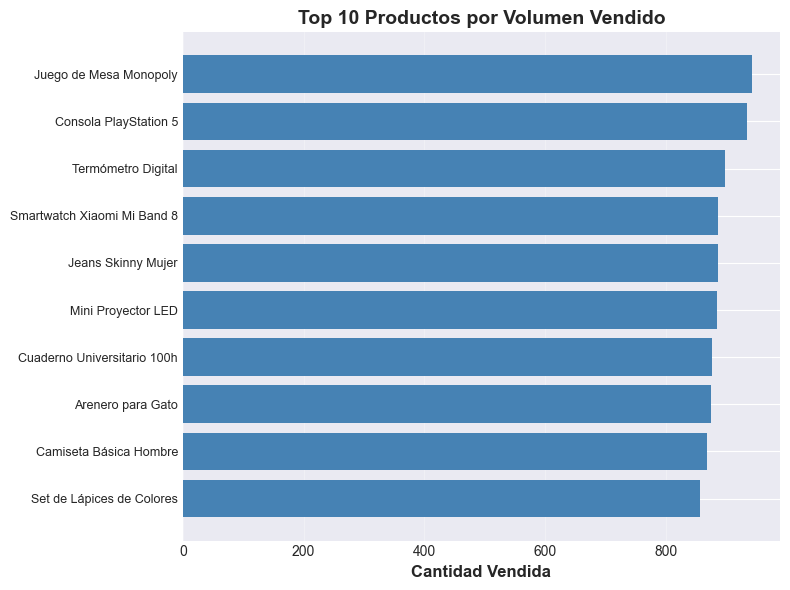


📊 Resumen:
   • Producto más vendido: Juego de Mesa Monopoly (942 unidades)
   • Total de unidades vendidas (Top 10): 8,908


In [12]:
# Consulta SQL para obtener los productos más vendidos por volumen
query_productos_vendidos = """
SELECT 
    p.producto_id,
    p.nombre AS producto_nombre,
    p.precio,
    c.nombre AS categoria_nombre,
    SUM(det.cantidad) AS total_vendido,
    SUM(det.cantidad * det.precio_unitario) AS total_recaudado
FROM detalle_ordenes det
INNER JOIN productos p ON det.producto_id = p.producto_id
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
GROUP BY p.producto_id, p.nombre, p.precio, c.nombre
ORDER BY total_vendido DESC
LIMIT 10;
"""

df_productos_vendidos = pd.read_sql(query_productos_vendidos, engine)

print("=" * 100)
print("PRODUCTOS MÁS VENDIDOS POR VOLUMEN (Top 10)")
print("=" * 100)
print(df_productos_vendidos.to_string(index=False))

# Visualización
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Gráfico de barras - Top 10 productos por volumen
top_10 = df_productos_vendidos.head(10)
ax1.barh(range(len(top_10)), top_10['total_vendido'], color='steelblue')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['producto_nombre'], fontsize=9)
ax1.set_xlabel('Cantidad Vendida', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Productos por Volumen Vendido', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Producto más vendido: {df_productos_vendidos.iloc[0]['producto_nombre']} ({df_productos_vendidos.iloc[0]['total_vendido']} unidades)")
print(f"   • Total de unidades vendidas (Top 10): {df_productos_vendidos['total_vendido'].sum():,.0f}")

## 2. ¿Cuál es el ticket promedio por orden?


ANÁLISIS DEL TICKET PROMEDIO POR ORDEN
 total_ordenes  ticket_promedio  ticket_minimo  ticket_maximo  ticket_mediana  ticket_q1  ticket_q3  desviacion_estandar
         10000      1216.380178          20.15       19226.99          560.01   293.6825   834.7375          2357.008103


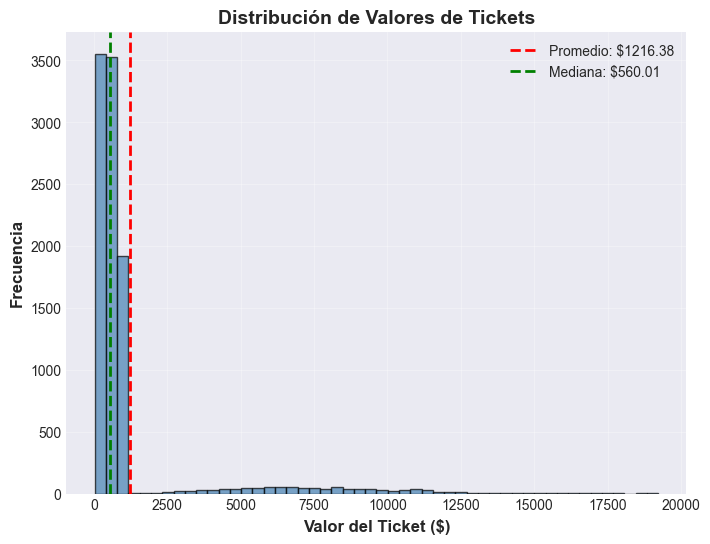

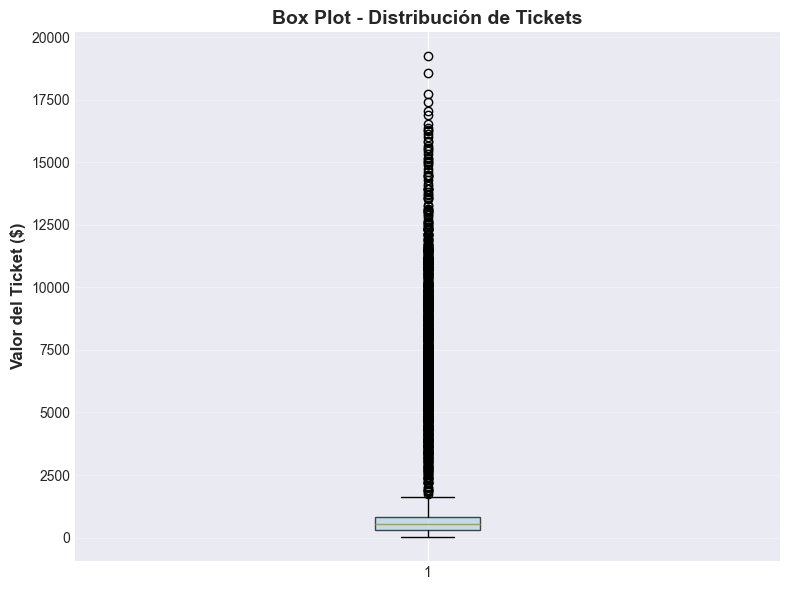


📊 Resumen:
   • Total de órdenes analizadas: 10,000
   • Ticket promedio: $1,216.38
   • Ticket mediana: $560.01
   • Ticket mínimo: $20.15
   • Ticket máximo: $19,226.99
   • Diferencia entre promedio y mediana: $656.37


In [15]:
# Consulta SQL para calcular el ticket promedio por orden
query_ticket_promedio = """
SELECT 
    COUNT(*) AS total_ordenes,
    AVG(total) AS ticket_promedio,
    MIN(total) AS ticket_minimo,
    MAX(total) AS ticket_maximo,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total) AS ticket_mediana,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total) AS ticket_q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total) AS ticket_q3,
    STDDEV(total) AS desviacion_estandar
FROM ordenes;
"""

df_ticket_promedio = pd.read_sql(query_ticket_promedio, engine)

print("=" * 100)
print("ANÁLISIS DEL TICKET PROMEDIO POR ORDEN")
print("=" * 100)
print(df_ticket_promedio.to_string(index=False))

# Obtener valores para visualización
ticket_promedio = float(df_ticket_promedio['ticket_promedio'].iloc[0])
ticket_mediana = float(df_ticket_promedio['ticket_mediana'].iloc[0])
ticket_min = float(df_ticket_promedio['ticket_minimo'].iloc[0])
ticket_max = float(df_ticket_promedio['ticket_maximo'].iloc[0])
total_ordenes = int(df_ticket_promedio['total_ordenes'].iloc[0])

# Consulta para obtener todos los tickets (sin agrupar)
query_todos_tickets = """
SELECT total
FROM ordenes
ORDER BY total;
"""

df_todos_tickets = pd.read_sql(query_todos_tickets, engine)

# Visualización
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig, ax2 = plt.subplots(1, 1, figsize=(8, 6))

# Histograma de distribución de tickets
ax1.hist(df_todos_tickets['total'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(ticket_promedio, color='red', linestyle='--', linewidth=2, label=f'Promedio: ${ticket_promedio:.2f}')
ax1.axvline(ticket_mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: ${ticket_mediana:.2f}')
ax1.set_xlabel('Valor del Ticket ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Valores de Tickets', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot(df_todos_tickets['total'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7))
ax2.set_ylabel('Valor del Ticket ($)', fontsize=12, fontweight='bold')
ax2.set_title('Box Plot - Distribución de Tickets', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de órdenes analizadas: {total_ordenes:,}")
print(f"   • Ticket promedio: ${ticket_promedio:,.2f}")
print(f"   • Ticket mediana: ${ticket_mediana:,.2f}")
print(f"   • Ticket mínimo: ${ticket_min:,.2f}")
print(f"   • Ticket máximo: ${ticket_max:,.2f}")
print(f"   • Diferencia entre promedio y mediana: ${abs(ticket_promedio - ticket_mediana):,.2f}")


## 3. ¿Cuáles son las categorías con mayor número de productos vendidos?


CATEGORÍAS CON MAYOR NÚMERO DE PRODUCTOS VENDIDOS
 categoria_id           categoria_nombre  productos_unicos_vendidos  total_unidades_vendidas  total_recaudado  ticket_promedio_categoria
           12                Videojuegos                          3                     2640        677175.81                 790.170140
            6          Juguetes y Juegos                          3                     2622        681765.17                 788.167827
            2                       Moda                          3                     2580        637860.24                 727.320684
            8         Libros y Papelería                          3                     2565        678118.98                 788.510442
           10                   Mascotas                          3                     2563        658441.48                 778.299622
           11       Tecnología y Gadgets                          3                     2549        647997.09                 77

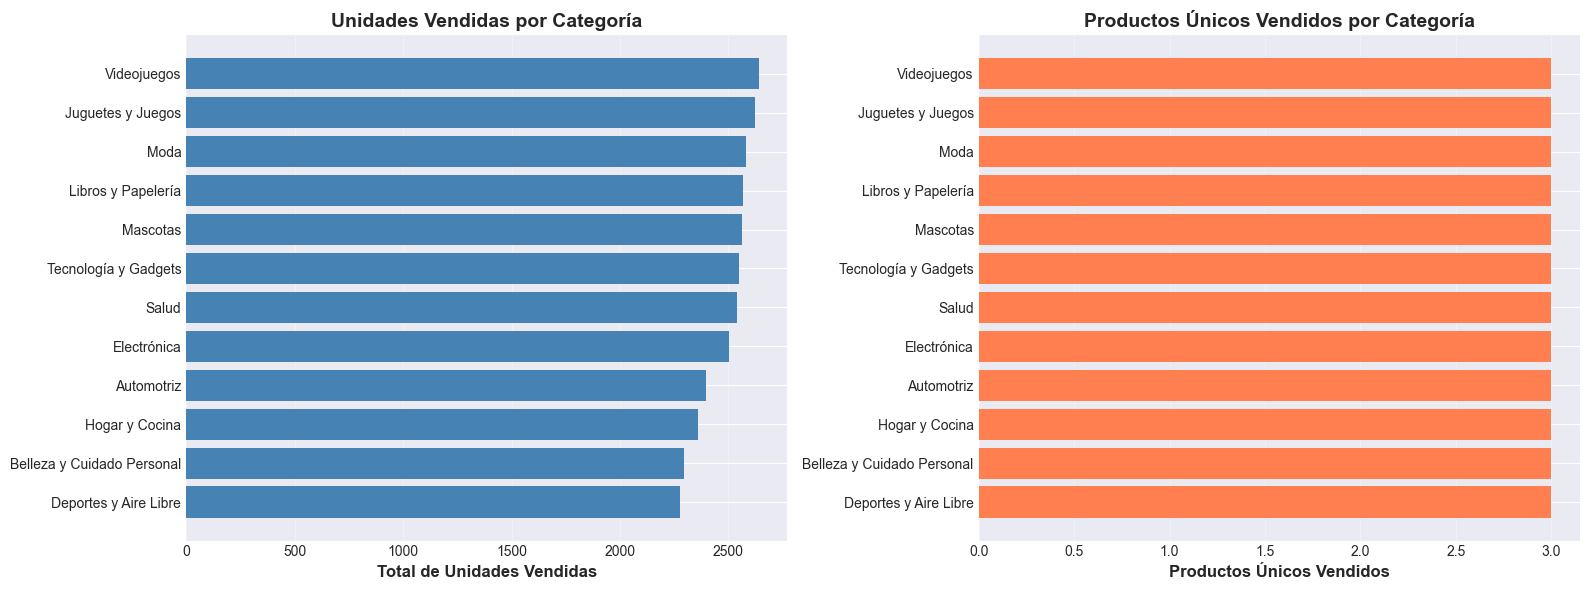

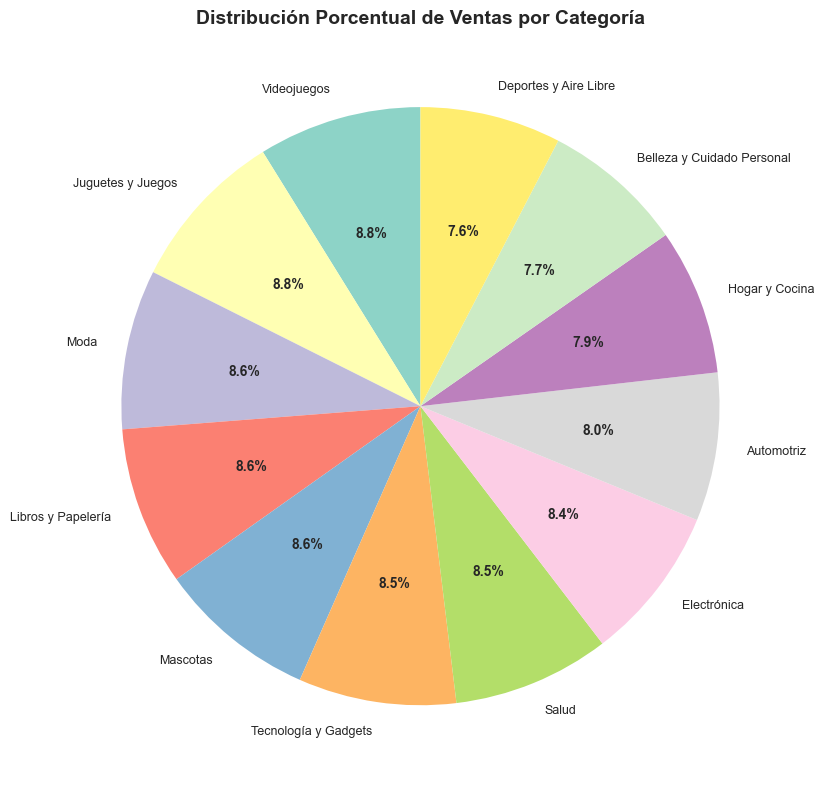


📊 Resumen:
   • Total de categorías con ventas: 12
   • Categoría con más unidades vendidas: Videojuegos (2,640 unidades)
   • Total de unidades vendidas: 29,889


In [17]:
# Consulta SQL para obtener las categorías con mayor número de productos vendidos
query_categorias_vendidas = """
SELECT 
    c.categoria_id,
    c.nombre AS categoria_nombre,
    COUNT(DISTINCT p.producto_id) AS productos_unicos_vendidos,
    SUM(det.cantidad) AS total_unidades_vendidas,
    SUM(det.cantidad * det.precio_unitario) AS total_recaudado,
    AVG(det.cantidad * det.precio_unitario) AS ticket_promedio_categoria
FROM detalle_ordenes det
INNER JOIN productos p ON det.producto_id = p.producto_id
INNER JOIN categorias c ON p.categoria_id = c.categoria_id
GROUP BY c.categoria_id, c.nombre
ORDER BY total_unidades_vendidas DESC;
"""

df_categorias_vendidas = pd.read_sql(query_categorias_vendidas, engine)

print("=" * 100)
print("CATEGORÍAS CON MAYOR NÚMERO DE PRODUCTOS VENDIDOS")
print("=" * 100)
print(df_categorias_vendidas.to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras - Unidades vendidas por categoría
ax1.barh(range(len(df_categorias_vendidas)), df_categorias_vendidas['total_unidades_vendidas'], 
         color='steelblue')
ax1.set_yticks(range(len(df_categorias_vendidas)))
ax1.set_yticklabels(df_categorias_vendidas['categoria_nombre'], fontsize=10)
ax1.set_xlabel('Total de Unidades Vendidas', fontsize=12, fontweight='bold')
ax1.set_title('Unidades Vendidas por Categoría', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Gráfico de barras - Productos únicos vendidos por categoría
ax2.barh(range(len(df_categorias_vendidas)), df_categorias_vendidas['productos_unicos_vendidos'], 
         color='coral')
ax2.set_yticks(range(len(df_categorias_vendidas)))
ax2.set_yticklabels(df_categorias_vendidas['categoria_nombre'], fontsize=10)
ax2.set_xlabel('Productos Únicos Vendidos', fontsize=12, fontweight='bold')
ax2.set_title('Productos Únicos Vendidos por Categoría', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Gráfico de pastel para distribución porcentual
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set3(range(len(df_categorias_vendidas)))
wedges, texts, autotexts = ax.pie(df_categorias_vendidas['total_unidades_vendidas'], 
                                   labels=df_categorias_vendidas['categoria_nombre'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax.set_title('Distribución Porcentual de Ventas por Categoría', fontsize=14, fontweight='bold')
plt.setp(autotexts, size=10, weight='bold')
plt.setp(texts, size=9)
plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de categorías con ventas: {len(df_categorias_vendidas)}")
print(f"   • Categoría con más unidades vendidas: {df_categorias_vendidas.iloc[0]['categoria_nombre']} ({df_categorias_vendidas.iloc[0]['total_unidades_vendidas']:,} unidades)")
print(f"   • Total de unidades vendidas: {df_categorias_vendidas['total_unidades_vendidas'].sum():,}")


## 4. ¿Qué día de la semana se generan más ventas?


VENTAS POR DÍA DE LA SEMANA
dia_espanol  total_ordenes  total_recaudado  ticket_promedio
    Domingo           1517       1873167.01      1234.783790
      Lunes           1415       1709305.17      1207.989519
     Martes           1385       1621829.03      1170.995690
  Miércoles           1412       1649072.38      1167.898286
     Jueves           1378       1633002.83      1185.052852
    Viernes           1407       1676511.36      1191.550362
     Sábado           1486       2000914.00      1346.510094


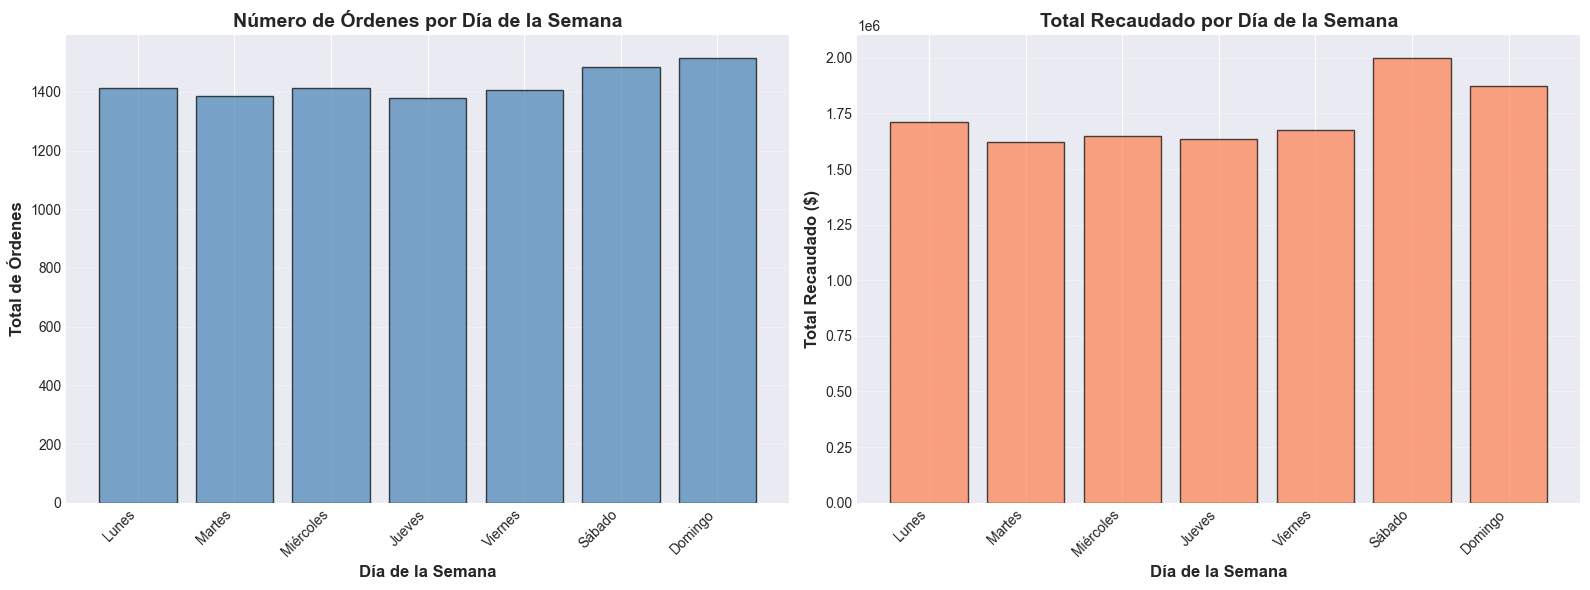


📊 Resumen:
   • Día con más órdenes: Domingo (1,517 órdenes)
   • Día con mayor recaudación: Sábado ($2,000,914.00)
   • Promedio de órdenes por día: 1428.6
   • Día con menor actividad: Jueves (1,378 órdenes)


In [18]:
# Consulta SQL para analizar ventas por día de la semana
query_ventas_dia_semana = """
SELECT 
    TO_CHAR(fecha_orden, 'Day') AS dia_semana_nombre,
    EXTRACT(DOW FROM fecha_orden) AS dia_semana_numero,
    COUNT(*) AS total_ordenes,
    SUM(total) AS total_recaudado,
    AVG(total) AS ticket_promedio
FROM ordenes
GROUP BY TO_CHAR(fecha_orden, 'Day'), EXTRACT(DOW FROM fecha_orden)
ORDER BY dia_semana_numero;
"""

df_ventas_dia_semana = pd.read_sql(query_ventas_dia_semana, engine)

# Limpiar nombres de días (eliminar espacios extra)
df_ventas_dia_semana['dia_semana_nombre'] = df_ventas_dia_semana['dia_semana_nombre'].str.strip()

# Mapear números a nombres en español
dias_espanol = {
    0: 'Domingo',
    1: 'Lunes',
    2: 'Martes',
    3: 'Miércoles',
    4: 'Jueves',
    5: 'Viernes',
    6: 'Sábado'
}

df_ventas_dia_semana['dia_espanol'] = df_ventas_dia_semana['dia_semana_numero'].map(dias_espanol)

print("=" * 100)
print("VENTAS POR DÍA DE LA SEMANA")
print("=" * 100)
print(df_ventas_dia_semana[['dia_espanol', 'total_ordenes', 'total_recaudado', 'ticket_promedio']].to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Ordenar por día de la semana (lunes a domingo)
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_ventas_dia_semana['orden'] = df_ventas_dia_semana['dia_espanol'].map({dia: i for i, dia in enumerate(orden_dias)})
df_ventas_dia_semana = df_ventas_dia_semana.sort_values('orden')

# Gráfico de barras - Número de órdenes por día
ax1.bar(df_ventas_dia_semana['dia_espanol'], df_ventas_dia_semana['total_ordenes'], 
        color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Día de la Semana', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total de Órdenes', fontsize=12, fontweight='bold')
ax1.set_title('Número de Órdenes por Día de la Semana', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Gráfico de barras - Total recaudado por día
ax2.bar(df_ventas_dia_semana['dia_espanol'], df_ventas_dia_semana['total_recaudado'], 
        color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Día de la Semana', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Recaudado ($)', fontsize=12, fontweight='bold')
ax2.set_title('Total Recaudado por Día de la Semana', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Encontrar el día con más ventas
dia_max_ordenes = df_ventas_dia_semana.loc[df_ventas_dia_semana['total_ordenes'].idxmax(), 'dia_espanol']
max_ordenes = df_ventas_dia_semana['total_ordenes'].max()
dia_max_recaudado = df_ventas_dia_semana.loc[df_ventas_dia_semana['total_recaudado'].idxmax(), 'dia_espanol']
max_recaudado = df_ventas_dia_semana['total_recaudado'].max()

print(f"\n📊 Resumen:")
print(f"   • Día con más órdenes: {dia_max_ordenes} ({max_ordenes:,} órdenes)")
print(f"   • Día con mayor recaudación: {dia_max_recaudado} (${max_recaudado:,.2f})")
print(f"   • Promedio de órdenes por día: {df_ventas_dia_semana['total_ordenes'].mean():.1f}")
print(f"   • Día con menor actividad: {df_ventas_dia_semana.loc[df_ventas_dia_semana['total_ordenes'].idxmin(), 'dia_espanol']} ({df_ventas_dia_semana['total_ordenes'].min():,} órdenes)")


## 5. ¿Cuántas órdenes se generan cada mes y cuál es su variación?


ÓRDENES POR MES Y VARIACIÓN
    Mes  Total Órdenes  Variación Absoluta  Variación %  Total Recaudado  Variación Recaudado %  Ticket Promedio
2024-06             25                 NaN          NaN         34984.90                    NaN      1399.396000
2024-07            828               803.0  3212.000000        934901.21            2572.299221      1129.107742
2024-08            864                36.0     4.347826       1163499.71              24.451621      1346.643183
2024-09            806               -58.0    -6.712963        969664.96             -16.659630      1203.058263
2024-10            838                32.0     3.970223       1041155.17               7.372671      1242.428604
2024-11            807               -31.0    -3.699284       1118424.33               7.421484      1385.903755
2024-12            847                40.0     4.956629        931100.29             -16.748924      1099.291960
2025-01            844                -3.0    -0.354191       112126

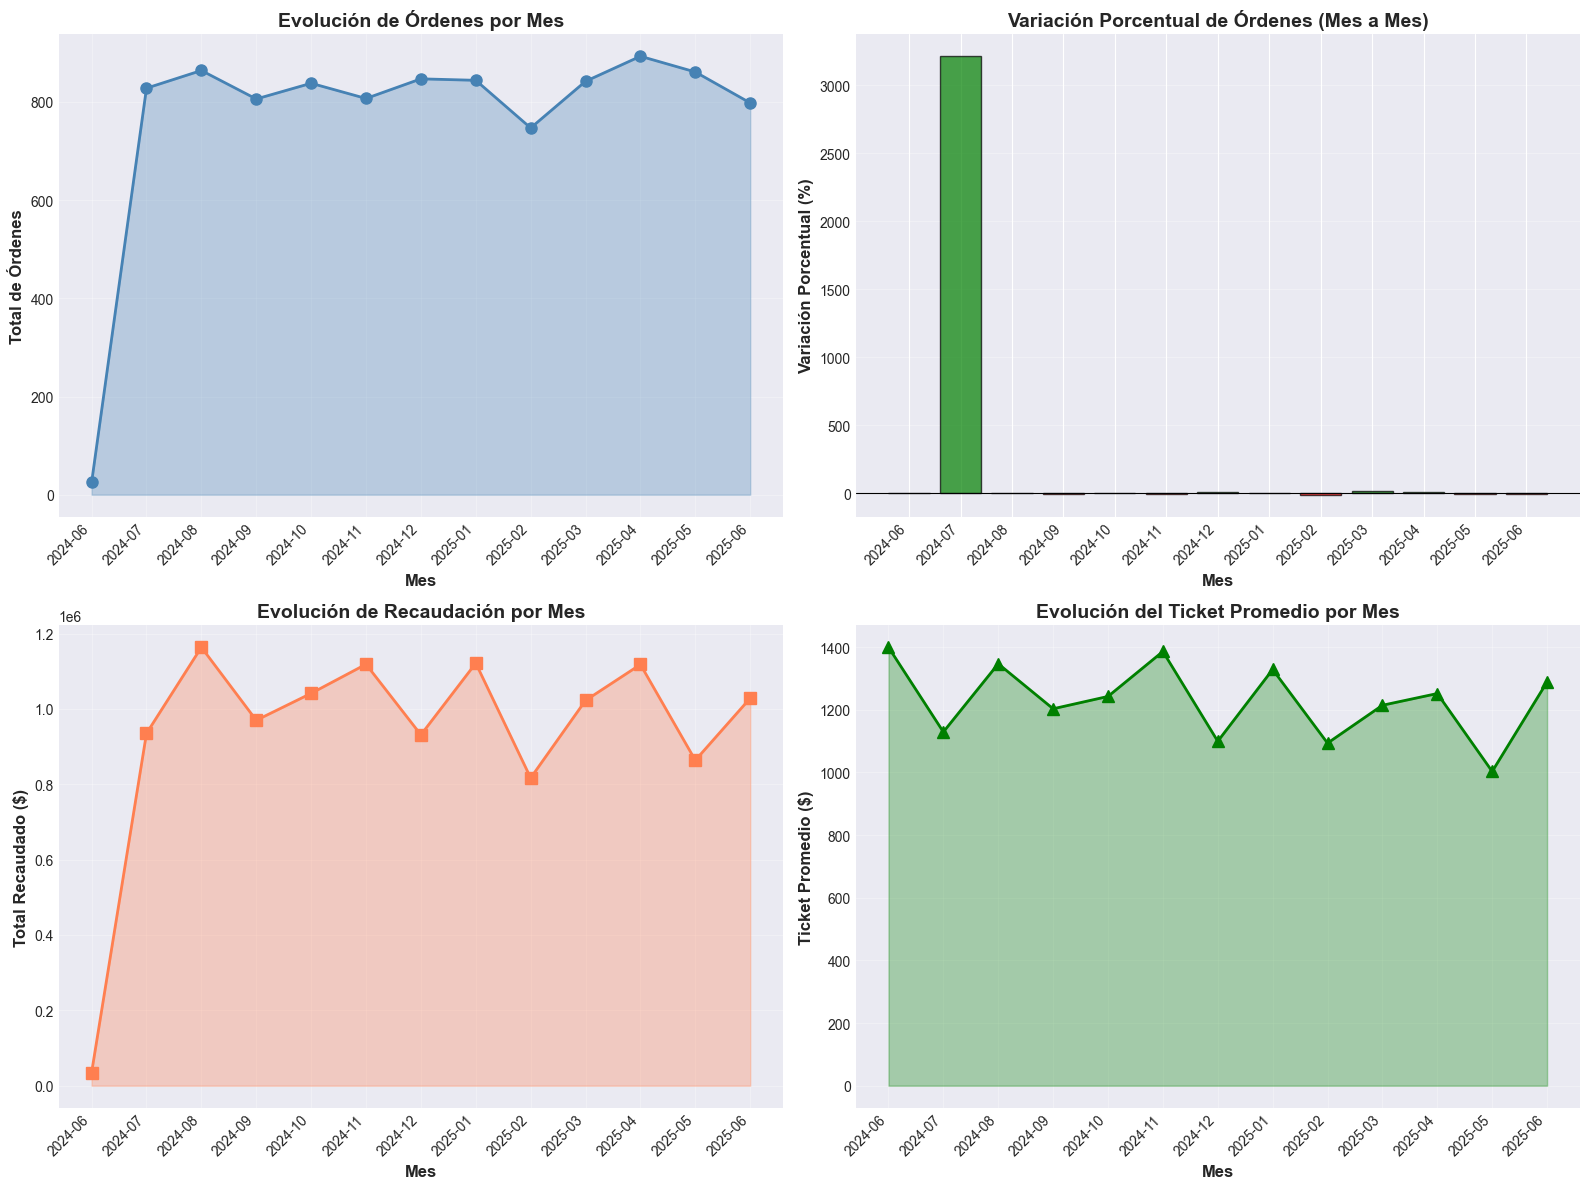


📊 Resumen:
   • Total de meses analizados: 13
   • Mes con más órdenes: 2025-04 (893 órdenes)
   • Mes con menos órdenes: 2024-06 (25 órdenes)
   • Promedio de órdenes por mes: 769.2
   • Desviación estándar: 226.5
   • Coeficiente de variación: 29.4%
   • Tendencia general: creciente
   • Variación promedio mes a mes: 273.10%


In [19]:
# Consulta SQL para analizar órdenes por mes
query_ordenes_mes = """
SELECT 
    DATE_TRUNC('month', fecha_orden) AS mes,
    TO_CHAR(fecha_orden, 'YYYY-MM') AS mes_formato,
    TO_CHAR(fecha_orden, 'Month YYYY') AS mes_nombre,
    COUNT(*) AS total_ordenes,
    SUM(total) AS total_recaudado,
    AVG(total) AS ticket_promedio,
    MIN(total) AS ticket_minimo,
    MAX(total) AS ticket_maximo
FROM ordenes
GROUP BY DATE_TRUNC('month', fecha_orden), TO_CHAR(fecha_orden, 'YYYY-MM'), TO_CHAR(fecha_orden, 'Month YYYY')
ORDER BY mes;
"""

df_ordenes_mes = pd.read_sql(query_ordenes_mes, engine)

# Calcular variación mes a mes
df_ordenes_mes['variacion_ordenes'] = df_ordenes_mes['total_ordenes'].pct_change() * 100
df_ordenes_mes['variacion_recaudado'] = df_ordenes_mes['total_recaudado'].pct_change() * 100
df_ordenes_mes['variacion_absoluta_ordenes'] = df_ordenes_mes['total_ordenes'].diff()

print("=" * 120)
print("ÓRDENES POR MES Y VARIACIÓN")
print("=" * 120)
display_cols = ['mes_formato', 'total_ordenes', 'variacion_absoluta_ordenes', 'variacion_ordenes', 
                'total_recaudado', 'variacion_recaudado', 'ticket_promedio']
df_display = df_ordenes_mes[display_cols].copy()
df_display.columns = ['Mes', 'Total Órdenes', 'Variación Absoluta', 'Variación %', 
                      'Total Recaudado', 'Variación Recaudado %', 'Ticket Promedio']
print(df_display.to_string(index=False))

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Línea temporal de órdenes por mes
ax1 = axes[0, 0]
ax1.plot(df_ordenes_mes['mes_formato'], df_ordenes_mes['total_ordenes'], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.fill_between(df_ordenes_mes['mes_formato'], df_ordenes_mes['total_ordenes'], 
                  alpha=0.3, color='steelblue')
ax1.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total de Órdenes', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de Órdenes por Mes', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Gráfico 2: Variación porcentual mes a mes
ax2 = axes[0, 1]
colors_variacion = ['green' if x >= 0 else 'red' for x in df_ordenes_mes['variacion_ordenes'].fillna(0)]
ax2.bar(df_ordenes_mes['mes_formato'], df_ordenes_mes['variacion_ordenes'].fillna(0), 
        color=colors_variacion, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax2.set_ylabel('Variación Porcentual (%)', fontsize=12, fontweight='bold')
ax2.set_title('Variación Porcentual de Órdenes (Mes a Mes)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Gráfico 3: Total recaudado por mes
ax3 = axes[1, 0]
ax3.plot(df_ordenes_mes['mes_formato'], df_ordenes_mes['total_recaudado'], 
         marker='s', linewidth=2, markersize=8, color='coral')
ax3.fill_between(df_ordenes_mes['mes_formato'], df_ordenes_mes['total_recaudado'], 
                  alpha=0.3, color='coral')
ax3.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Recaudado ($)', fontsize=12, fontweight='bold')
ax3.set_title('Evolución de Recaudación por Mes', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Gráfico 4: Ticket promedio por mes
ax4 = axes[1, 1]
ax4.plot(df_ordenes_mes['mes_formato'], df_ordenes_mes['ticket_promedio'], 
         marker='^', linewidth=2, markersize=8, color='green')
ax4.fill_between(df_ordenes_mes['mes_formato'], df_ordenes_mes['ticket_promedio'], 
                  alpha=0.3, color='green')
ax4.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax4.set_ylabel('Ticket Promedio ($)', fontsize=12, fontweight='bold')
ax4.set_title('Evolución del Ticket Promedio por Mes', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Estadísticas resumen
mes_max_ordenes = df_ordenes_mes.loc[df_ordenes_mes['total_ordenes'].idxmax(), 'mes_formato']
max_ordenes = df_ordenes_mes['total_ordenes'].max()
mes_min_ordenes = df_ordenes_mes.loc[df_ordenes_mes['total_ordenes'].idxmin(), 'mes_formato']
min_ordenes = df_ordenes_mes['total_ordenes'].min()
promedio_ordenes = df_ordenes_mes['total_ordenes'].mean()
desviacion_ordenes = df_ordenes_mes['total_ordenes'].std()

# Calcular tendencia (usando regresión lineal simple)
x = np.arange(len(df_ordenes_mes))
y = df_ordenes_mes['total_ordenes'].values
coef = np.polyfit(x, y, 1)
tendencia = "creciente" if coef[0] > 0 else "decreciente" if coef[0] < 0 else "estable"

print(f"\n📊 Resumen:")
print(f"   • Total de meses analizados: {len(df_ordenes_mes)}")
print(f"   • Mes con más órdenes: {mes_max_ordenes} ({max_ordenes:,} órdenes)")
print(f"   • Mes con menos órdenes: {mes_min_ordenes} ({min_ordenes:,} órdenes)")
print(f"   • Promedio de órdenes por mes: {promedio_ordenes:.1f}")
print(f"   • Desviación estándar: {desviacion_ordenes:.1f}")
print(f"   • Coeficiente de variación: {(desviacion_ordenes/promedio_ordenes)*100:.1f}%")
print(f"   • Tendencia general: {tendencia}")
print(f"   • Variación promedio mes a mes: {df_ordenes_mes['variacion_ordenes'].abs().mean():.2f}%")
